# Exercise 4: recommender System

In [2]:
#check if notebook runs in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone https://github.com/keuperj/DataScienceSS20.git
  path='DataScienceSS20'

running in Colab: False


## Code from the lecture

In [3]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(path+'/DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(path+'/DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(path+'/DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [4]:
def getTopN(movie_id,D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title, D):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title),D))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [5]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [6]:
import scipy.spatial
D=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='cosine'))
D=np.abs(np.nan_to_num( D-1)) #dist to similarity 
np.fill_diagonal(D,0) #set self-dist to zero

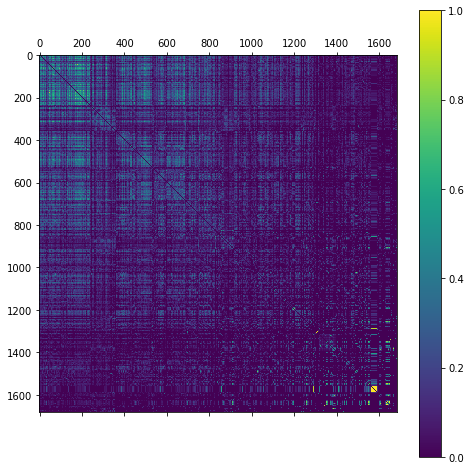

In [7]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D)
plt.colorbar() 

In [8]:
print(CII("Titanic", D))

recommending movies for: 'Titanic (1997)'
271      Good Will Hunting (1997)
257                Contact (1997)
314              Apt Pupil (1998)
750    Tomorrow Never Dies (1997)
299          Air Force One (1997)
Name: title, dtype: object


## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

In [9]:
import scipy.spatial
#Euklidische Distanz:
E=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='euclidean'))
#Distanz zu Ähnlichkeit transformieren.
Emax = E.max() # maximaler Abstand
E=np.abs(np.nan_to_num((E/Emax)-1))
np.fill_diagonal(E,0) #setzen der Ähnlichkeit des gleichen Films zu 0

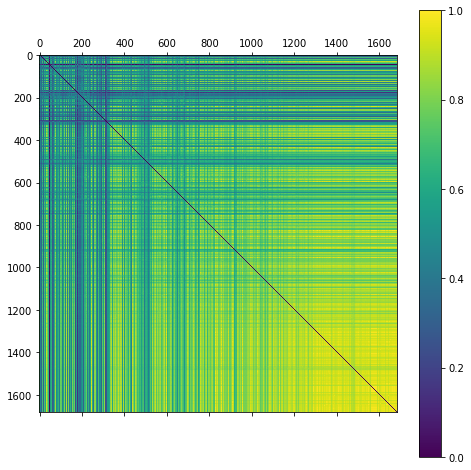

In [10]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(E)
plt.colorbar() 

In [11]:
print(CII("Titanic",E))

recommending movies for: 'Titanic (1997)'
271      Good Will Hunting (1997)
314              Apt Pupil (1998)
750    Tomorrow Never Dies (1997)
346            Wag the Dog (1997)
749                Amistad (1997)
Name: title, dtype: object


## 4.2 Baseline Results
Implement and compare results of
* random recommendations
* allways recommending the top 5 movies (over all users)

In [12]:
#Berechnen der Vorschläge für Test-Satz mit Distanzmatrix E und D. Vergleich der Ergebnisse. 
def compare_RC(D,E, R_test):
    userScores=[]
    for e in range(R_test.shape[0]):
        sameIds = compare_byID(e,D,E)
        userScores.append(sameIds)
    return userScores

def compare_byID(ID, D, E):
    res_idD = getTopN(ID,D)[::-1]
    res_idE = getTopN(ID,E)[::-1]  
    
    sameIds = 0
    for i in res_idD:
        if i in res_idE:
            sameIds += 1
            
    return sameIds

In [13]:
from sklearn.model_selection import train_test_split
R_train, R_test = train_test_split(R, test_size=0.1)

(array([40.,  0., 25.,  0., 17.,  0., 10.,  0.,  2.,  1.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

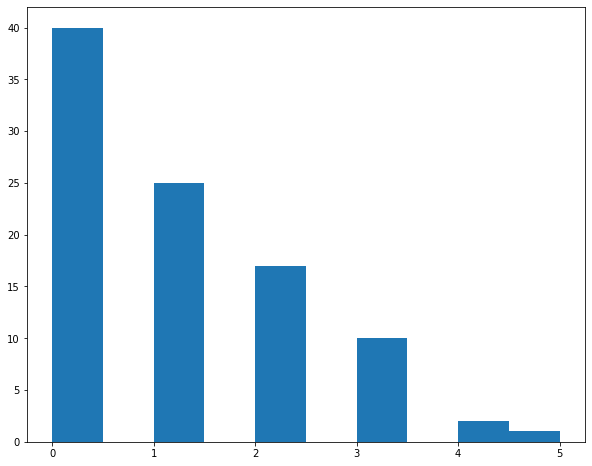

In [14]:
test_res= compare_RC(D,E,R_test)
plt.hist(test_res)

## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $R$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct R and evaluate $R'$
* compute the distance between two movies using $R'$

In [15]:
U,S,V = np.linalg.svd(R)

In [16]:
print(S.shape)
print(U.shape)
print(V.shape)

(943,)
(943, 943)
(1682, 1682)


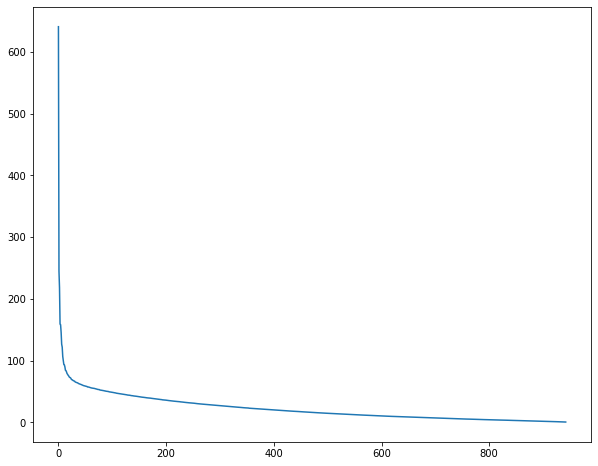

In [17]:
plt.subplot()
plt.plot(S)

In [19]:
np.allclose(R_train, np.dot(U*S,V[:943,:]))

ValueError: operands could not be broadcast together with shapes (848,1682) (943,1682) 

In [20]:
Rdash = np.dot(U[:,:600] * S[:600],V[:600,:])

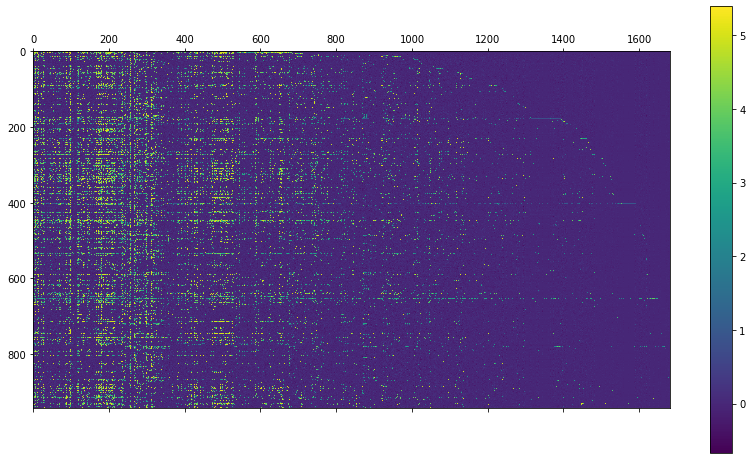

In [21]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(Rdash)
plt.colorbar() 

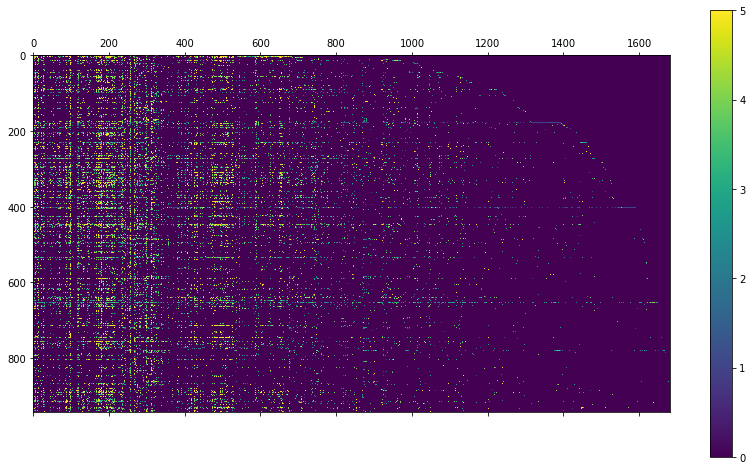

In [22]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(R)
plt.colorbar() 

In [272]:
import scipy.spatial
F=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Rdash.T, metric='cosine'))
F=np.abs(np.nan_to_num(F-1)) #dist to similarity 
np.fill_diagonal(F,0) #set self-dist to zero

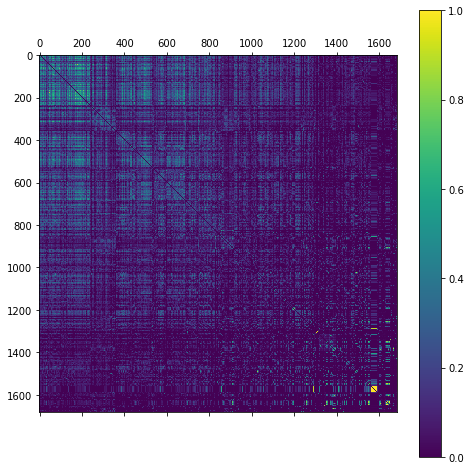

In [273]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(F)
plt.colorbar() 

In [274]:
CII("Titanic", F)

recommending movies for: 'Titanic (1997)'


271      Good Will Hunting (1997)
257                Contact (1997)
314              Apt Pupil (1998)
750    Tomorrow Never Dies (1997)
299          Air Force One (1997)
Name: title, dtype: object